# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

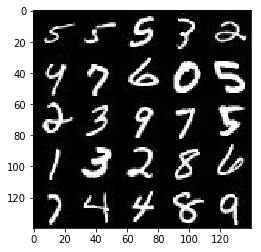

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

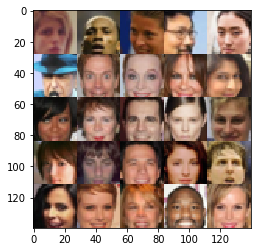

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_image")
    z_dim = tf.placeholder(tf.float32, (None, z_dim), name = "z_dim")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_image, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256) # First fully connected layer
        x1 = tf.reshape(x1, (-1, 7, 7, 256)) # Reshape it to start the convolutional stack
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x5
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


32### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                            labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                            labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                if steps % 100 == 0: show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                    
        show_generator_output(sess, 10, input_z, image_channels, data_image_mode)        
        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 29.4219
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 12.9992
Epoch 1/2... Discriminator Loss: 0.7033... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 16.3535
Epoch 1/2... Discriminator Loss: 0.0170... Generator Loss: 9.2424
Epoch 1/2... Discriminator Loss: 0.3184... Generator Loss: 11.0325
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 3.9179
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 0.5868... Generator Loss: 1.4976
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 2.7941


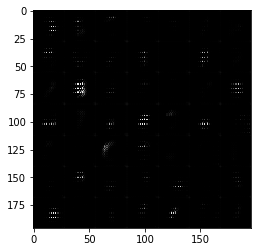

Epoch 1/2... Discriminator Loss: 1.8947... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 2.7890
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.2230
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 2.0092... Generator Loss: 3.4624
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 2.2774
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.5017


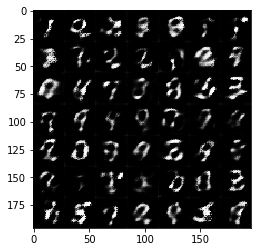

Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.7740
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 2.7375
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.1921
Epoch 1/2... Discriminator Loss: 1.4386... Generator Loss: 0.4858
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 2.3653


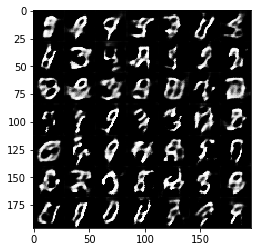

Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.8510... Generator Loss: 0.2419
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.9485
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.5782


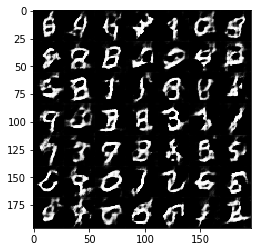

Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 1.9218


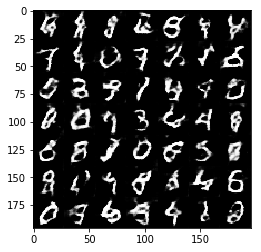

Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 1.3308
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 1.8020


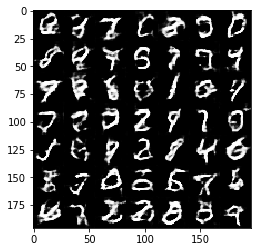

Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 1.1356
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 1.2883
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.1168


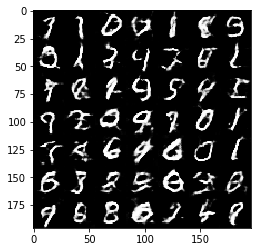

Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.3285
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 2.0409
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 1.4217
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 1.0530


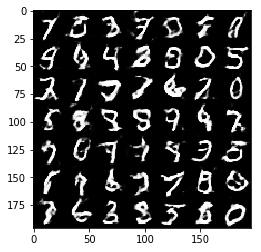

Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 2.7073... Generator Loss: 0.1064
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.5250
Epoch 1/2... Discriminator Loss: 2.6679... Generator Loss: 0.1083


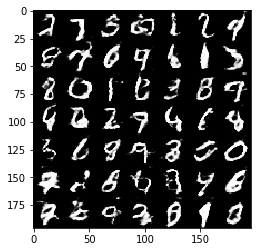

Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.3039
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.4644
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 1.3861


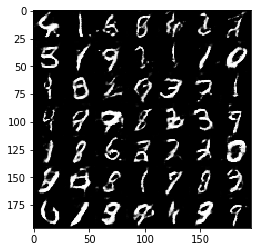

Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.7348
Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 1.2821
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.6339... Generator Loss: 0.3461
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.4064


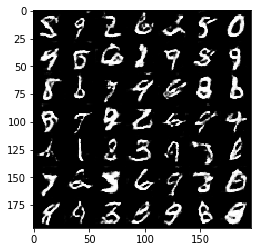

Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 1.4790
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.0315
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.7304... Generator Loss: 2.9671
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.6300


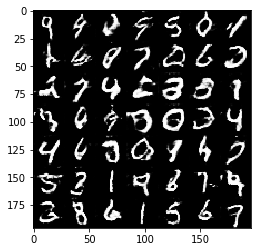

Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.3754
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 1.5619... Generator Loss: 0.3578
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 0.9822
Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.3629
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 2.1752


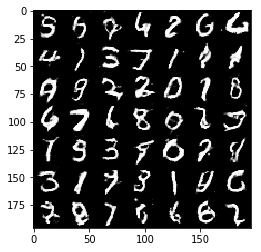

Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.2095
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.0400
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.1320
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 2.5273
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.8132


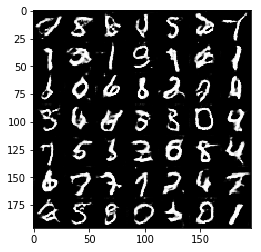

Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 0.3975
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.3913
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.4747
Epoch 2/2... Discriminator Loss: 1.5414... Generator Loss: 2.6677
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.9469
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.5486


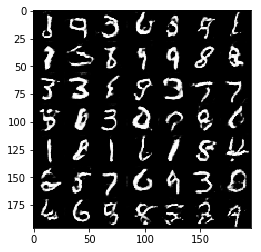

Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 1.4851
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 2.4468
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.3990
Epoch 2/2... Discriminator Loss: 1.7796... Generator Loss: 0.3043
Epoch 2/2... Discriminator Loss: 1.6693... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.7513


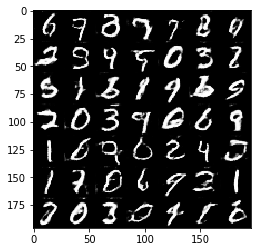

Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 0.9553
Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 2.1678
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.1200
Epoch 2/2... Discriminator Loss: 0.6931... Generator Loss: 1.3112
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.6037
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 1.4741
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.2429


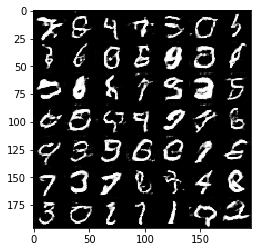

Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 2.7424
Epoch 2/2... Discriminator Loss: 0.4689... Generator Loss: 1.8786
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 3.2937
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.4856
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.1323


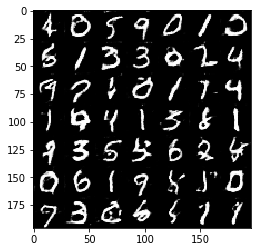

Epoch 2/2... Discriminator Loss: 0.4453... Generator Loss: 1.5720
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.3069
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 1.8879... Generator Loss: 0.4205


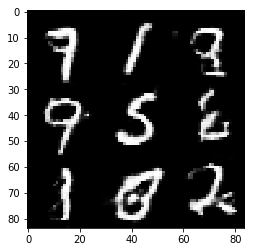

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.5531... Generator Loss: 0.0181
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 3.8001
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 4.6862
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 2.6712
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 3.0951
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 1.5452
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.1516... Generator Loss: 4.9112
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 6.2315


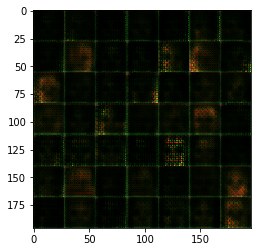

Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 3.3913
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 2.7398
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.9264... Generator Loss: 2.1052


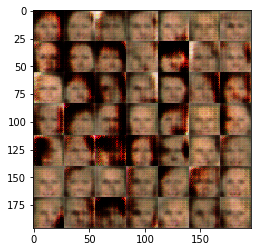

Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7341


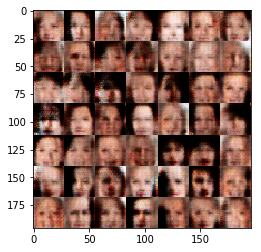

Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.9063... Generator Loss: 0.2595
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9916


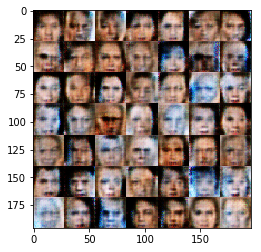

Epoch 1/1... Discriminator Loss: 1.8879... Generator Loss: 1.8893
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.9028


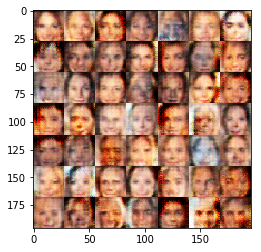

Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6807


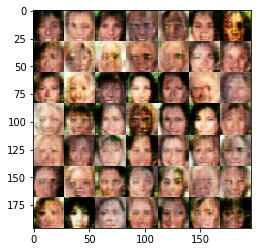

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 2.4580... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 0.9832


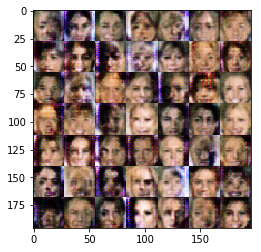

Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.7934


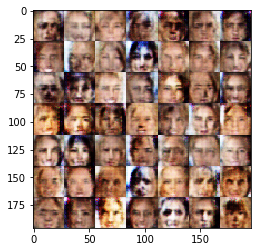

Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.8742... Generator Loss: 2.2363


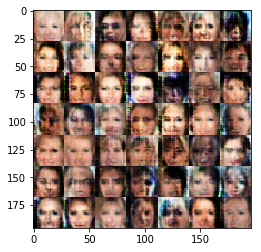

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5421


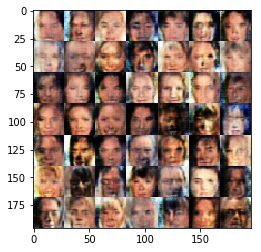

Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.4653


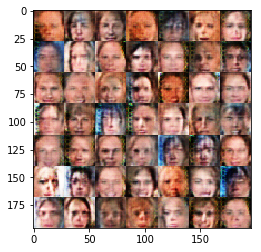

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8570


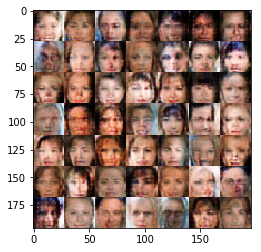

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5996


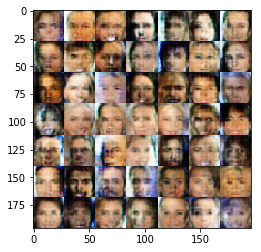

Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5482


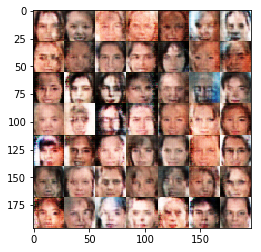

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7363


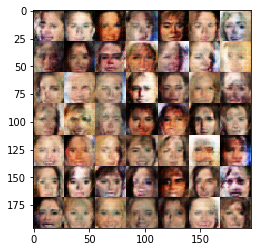

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6930


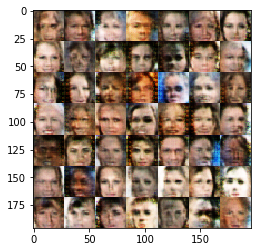

Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8043


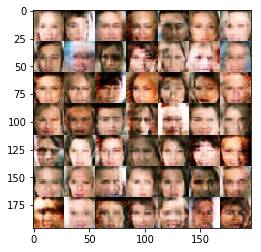

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7088


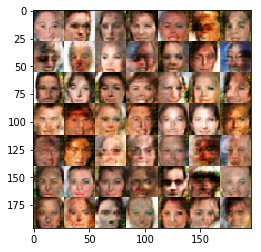

Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6626


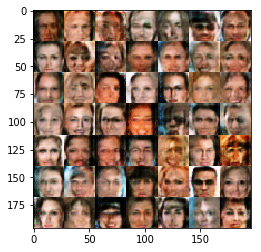

Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.4896


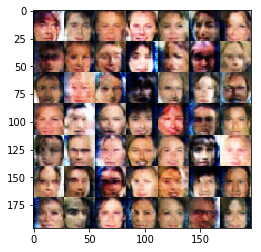

Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.9793


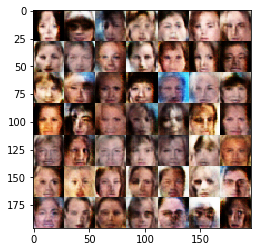

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 2.0085... Generator Loss: 1.7988
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7475


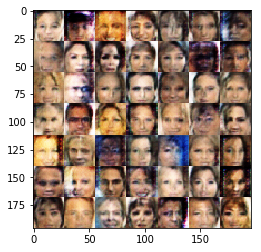

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.5039


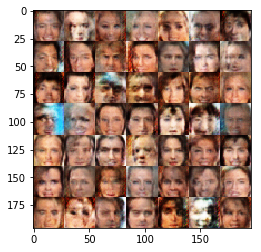

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.9005


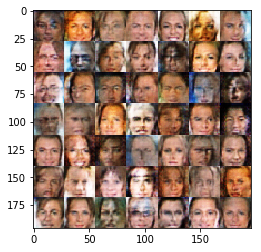

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.5982


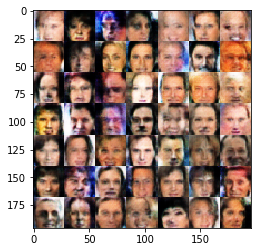

Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8252


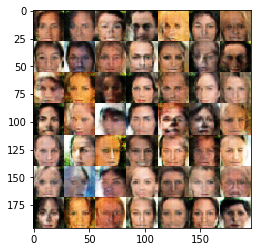

Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.0816


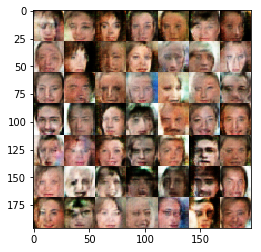

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.4971


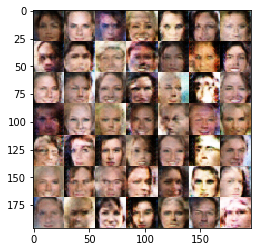

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7549


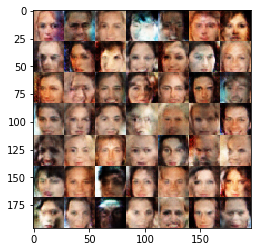

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7097


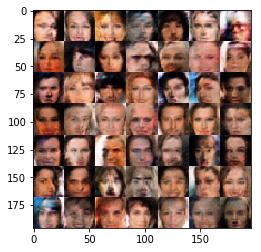

Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.9567


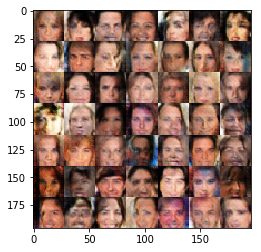

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5712


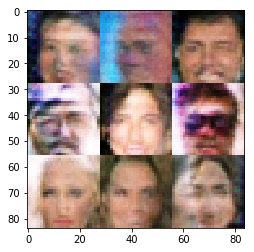

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.